# DDPM：去噪扩散概率模型学习笔记

In [24]:
from graphviz import Digraph
import matplotlib.pyplot as plt
from PIL import Image

## 1 数学基础

### 1 似然（Likelihood）
如果说概率衡量的是 $X$ 发生的可能性，那么似然衡量的就是 $X$ 发生时参数为 $θ$ 的可能性。因此，似然函数定义如下：
$$
L(\theta|X) = P(X|\theta)
$$
例如 $X=2$ 发生时，参数 $\theta = 1$ 的似然就是 $P(X=2|\theta = 1)$，在形式上与条件概率相同。

### 2 DDPM 中的 Markov Chain
马尔可夫性质是说，在给定当前状态 $x_t$ 的情况下，未来的状态 $x_{t+1}$ 只与当前状态 $x_t$ 有关，与过去的状态 $x_{t-1}, x_{t-2}, \cdots$ 无关。也就是说，当下的状态已经蕴含了过去的信息，因此立足当下就能预测未来。

在图片处理过程中需要经过多次处理，每次处理都会产生一张新的图片。把每一张图片都看作一个状态，那么图片处理的过程（把第 $t$ 张图变化为第 $t + 1$ 张图）就可以用一个条件概率来描述,对于第 $t$ 张图，它的生成离不开前面所有的图片，即：
$$
p(x_{t}|x_0,x_1,x_2,\cdots,x_{t-1})
$$
根据马尔可夫性质：
$$
p(x_t|x_{t-1}) = p(x_{t}|x_0,x_1,x_2,\cdots,x_{t-1})
$$
以上被称作状态之间的转移概率。

我们考虑联合分布，并应用马尔可夫性质：
$$
\begin{aligned}
p(x_0,x_1,x_2,\cdots,x_T)=p(x_0)p(x_1|x_0)p(x_2|x_0,x_1)p(x_3|x_0,x_1,x_2)\cdots \\
=p(x_0)p(x_1|x_0)p(x_2|x_1)p(x_3|x_2)\cdots \\
\end{aligned}
$$
这样，联合分布就简化为了众多的条件概率乘积，因此我们只需要了解逐步的概率转移分布，就可以逐步地变换图片，最终达成我们想要的结果了。这就是后面概率建模的理论基础。

### 3 变分推断和 ELBO
*这个 VAE 也用过*

假设 $p(z|x)$ 是难以计算的函数，而 $q(z)$ 是易于计算的函数且 $p≈q$，其散度为 $D_{KL}(p||q) = \mathbb{E}_{z\sim q}[log\frac{q}{p}]$（这个符号的意思是 $\int f(z)q(z)dz$）

然后把常数项提出来：
$$
D_{KL}(p||q) = \mathbb{E}_{z\sim q}[logp(x)+log\frac{q(z)}{p(z,x)}]=\mathbb{E}_{z\sim q}[log\frac{q(z)}{p(z,x)}]+logp(x)
$$

因此，
$$
const ~~ logp(x) = D + \mathbb{E}[log \frac{q}{p}]
$$
右边那一项被称为 ELBO，并有 $ELBO \leq LHS$

## 2 建模

### 1 前向过程/扩散过程
我们现在有一张图片 $\mathbf{x}_0$，我们需要将其转化为一张噪声图片 $\mathbf{x}_T$。（$T$ 是总时间步：也就是需要添加多少次噪声）。首先我们用如下的马尔可夫过程来表示逐步加入高斯噪声：
$$
q(\mathbf{x}_t|\mathbf{x}_{t-1}):=\mathcal{N}(\mathbf{x}_t;\sqrt{1-\beta_t}\mathbf{x}_{t-1},\beta_t\mathbf{I})
$$
由概率论：
$$
\mathbb{E}[\mathbf{x}_t \mid \mathbf{x}_{t-1}]=\sqrt{{\alpha}_t}\mathbf{x}_{t-1}
$$
$$
\mathbb{E}[\mathbb{E}[\mathbf{x}_t \mid \mathbf{x}_{t-1}]]=\mathbb{E}[\mathbf{x}_t]=\sqrt{{\alpha}_t}\mathbb{E}[\mathbf{x}_{t-1}]
$$
利用重参数化技巧:
$$
\mathbf{x}_t=\sqrt{{\alpha}_t}\mathbf{x}_{t-1}+\sqrt{1-{\alpha}_t}\mathbf{\epsilon}_t ~~ \mathrm{where} ~~ \mathbf{\epsilon}_t\sim\mathcal{N}(\mathbf{0},\mathbf{I})
$$
根据递推：
$$
\mathbf{x}_t=\sqrt{\prod_t{\alpha}_t}\mathbf{x}_{0}+\sqrt{1-\prod_t {\alpha}_t}\mathbf{\epsilon}_0 ~~...~~ (注意下标哦)
$$
*上式在展开的时候涉及到了独立正态分布相加，最终化为一个 $\epsilon_0$ 的过程*

*解释一下上式中涉及的i.i.d.正态分布之和：假设 $X$ 和 $Y$ 均为 $N(0,1)$，则 $aX+bY \sim N(0,a^2+b^2)$，可以标准化表示为 $\sqrt{a^2+b^2}Z$*

因此 $\mathbf{x}_t \sim \mathcal{N}({\prod_t {\alpha}_t}, ({1-\prod_t {\alpha}_t})\mathbf{I})$，在本篇论文中 $\alpha$ 和 $\beta$ 都是固定的并且位于 $(0,1)$，所以 $T$ 比较大时，$\mathbf{x}_T$ 就会趋近标准的正态分布。

需要指出的是，由于作者说了这两个“超参数”是固定的，因此前向扩散根本不需要搭建神经网络。

### 2 反向过程/去噪过程
现在我们已经得到了一张纯噪声图，接下来定义一个神经网络，学习参数 $\theta$，执行反向的去噪过程（也是马尔可夫的）。
$$
\begin{aligned}
p_\theta(\mathbf{x}_{0:T}):=p(\mathbf{x}_T)\prod_{t=1}^Tp_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t),\quad & p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t):=\mathcal{N}(\mathbf{x}_{t-1};\boldsymbol{\mu}_\theta(\mathbf{x}_t,t),\boldsymbol{\Sigma}_\theta(\mathbf{x}_t,t))
\end{aligned}
$$
也就是说我们每一步的转移概率分布都是正态分布，其参数由神经网络 $\theta$ 和时间步数 $t$ 决定。

### 3 思考：为什么要这样做？
原始图片涉及的概率分布是十分复杂的，并没有成熟的数学方法去描述。

但是我们通过加噪声的方式把图片变成一个正态分布，然后再用一系列的正态分布去转移它，让它逼近原始图片的概率分布。这个反向过程是很明朗的，而且很容易用数学去解释。

这其实和VAE很像，只不过VAE的着眼点在于控制图片生成背后的隐变量，并寻找它的规律，而在DDPM中我们只关心用一系列的马尔可夫过程去逼近原始的图片。

### 4 优化目标函数

我们采用 $\mathbf{x}_0$ 的负对数似然（LHS）：

$$
\mathbb{E \left[-\log p_{\theta}(\mathbf{x}_0)\right]}
$$


这个 $p_\theta$ 是不好算的，我们回忆一下上文中的 $q$，这些全部是性质很好的正态分布，它们的先验分布我们全都知道，而且正好先验分布 $q_{t|t-1}$ 就是 $p_{\theta}$ 的后验。
如果能代入这个已知条件，问题就会简化很多。因此我们考虑利用变分下界的方法:

$$
\mathbb{E \left[-\log p_{\theta}(\mathbf{x}_0)\right]} \leq \mathbb{E} [-ELBO]=\mathbb{E}_q\left[-\log\frac{p_\theta(\mathbf{x}_{0:T})}{q(\mathbf{x}_{1:T}|\mathbf{x}_0)}\right]
$$
这里我们代入 1.3 中的公式得到：
$$
-\mathbb{E}_q\left[\log p(\mathbf{x}_T)+\sum_{t\geq1}\log\frac{p_\theta(\mathbf{x}_{t-1}|\mathbf{x}_t)}{q(\mathbf{x}_t|\mathbf{x}_{t-1})}\right]=:L
$$

引入 **前向过程的后验分布** $q(\mathbf{x}_{t-1}|\mathbf{x}_t,\mathbf{x}_0)=\frac{q(\mathbf{x}_t|\mathbf{x}_{t-1})q(\mathbf{x}_{t-1}|\mathbf{x}_0)}{q(\mathbf{x}_t|\mathbf{x}_0)}$(这一分布也是正态分布，并且其参数已知)

代入原式中，可以简化为求多个正态分布之间的KL散度和：
$$
\mathbb{E}_q[L_T+\sum L_{t-1}+L_0]
$$
其中
$$
L_0=\log p_{\theta}(x_0\mid x_1)
$$
$$
L_{t-1}=D_{\mathrm{KL}}(q(\mathbf{x}_{t-1}|\mathbf{x}_{t},\mathbf{x}_{0})\parallel p_{\theta}(\mathbf{x}_{t-1}|\mathbf{x}_{t}))
$$
$$
L_T=D_{\mathrm{KL}}(q(\mathbf{x}_{T}|\mathbf{x}_{0})\parallel p(\mathbf{x}_{T}))
$$

**这一步的好处在于，将一系列的复杂分布转换为了正态分布，因此可以直接用现有的解析解计算，简化了算法。**

### 5 预测噪声

**我们的目标是对 $p_{\theta}(x)$ 的参数进行优化，使得它逼近 $q$ 。（这也是KL散度的实际意义）**

根据上面的推导，我们可以把问题转化为对该分布的均值 $\mu_{\theta}$ 进行计算:
$$L_{t-1}=\mathbb{E}_q\left[\frac{1}{2\sigma_t^2}\|\tilde{\boldsymbol{\mu}}_t(\mathbf{x}_t,\mathbf{x}_0)-\boldsymbol{\mu}_\theta(\mathbf{x}_t,t)\|^2\right]+C$$

根据 2.1 的重参数化技巧。我们这里有：
$$\tilde{\mu}_t=\frac{1}{\sqrt{\alpha_t}}\left(x_t-\frac{\beta_t}{\sqrt{1-\alpha_t}}\epsilon\right)$$

**2.1的重参数化技巧形象地表现了这种加噪过程，那么对于反向去噪这一过程，我们也可以采用重参数化技巧，把对分布函数的研究变为对噪声的研究**

我们将 $\mu_{\theta}$ 重参数化为：
$$\begin{aligned}\frac{1}{\sqrt{\alpha_t}}\left(\mathbf{x}_t-\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\boldsymbol{\epsilon}_\theta(\mathbf{x}_t,t)\right)\end{aligned}$$

最终的目标函数简化为 MSE 形式：
$$
\mathbb{E}_{\mathbf{x}_0,\epsilon}\left[||\epsilon - \epsilon_{\theta}||^2\right]
$$
**正如我们将前向的转移概率解释为添加噪声一样，我们反向的学习目标也通过重参数化，将涉及复杂概率分布的计算变为简单的噪声计算**

下面这张图展示了论文中一步步推导目标函数的过程


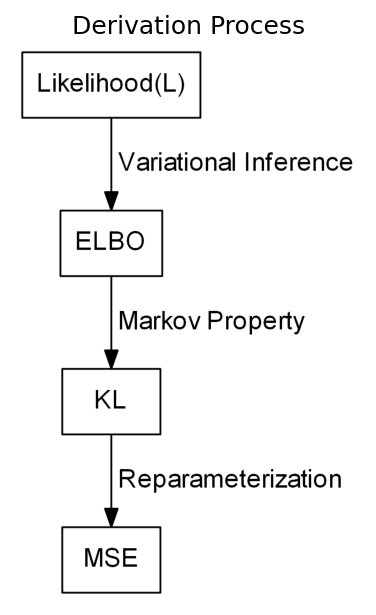

In [25]:
dot = Digraph(comment='Optimization', node_attr={'fontname': 'Helvetica,Arial,sans-serif'},
              edge_attr={'fontname': 'Helvetica,Arial,sans-serif'},graph_attr={'size':'4,4'})
dot.attr(dpi='300')

dot.node('ll', 'Likelihood(L)', shape='rectangle')
dot.node('el', 'ELBO', shape='rectangle')
dot.node('kl', 'KL', shape='rectangle')
dot.node('ms', 'MSE', shape='rectangle')

dot.edge('ll', 'el', label=' Variational Inference')
dot.edge('el', 'kl', label=' Markov Property')
dot.edge('kl', 'ms', label=' Reparameterization')

img_path = 'opt'
dot.render(img_path, format='png', cleanup=True, view=False)
print('下面这张图展示了论文中一步步推导目标函数的过程')
img = Image.open(f'{img_path}.png')
plt.title('Derivation Process')
plt.rcParams['figure.dpi'] = 150
plt.imshow(img)
plt.axis('off')
plt.show()